**Word Embeddings**

Convert tokens to vectors of real numbers based on usage and context.

- Using Two Layer (Linear) Neural Network 

Feed $(n)$ one hot encoded samples call $X$  to Neural Network. Let $W_1(r,n)$ and $W_2(n,r)$ be weights of the first and second layer respectively. 

$Out = Softmax(W_{2}W_{1}X)$

The W1 weights are the representation vectors where each word has r dimensional vector.


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [23]:
class WordEmbeddings:

    def __init__(self,m,r):

        self.model = nn.Sequential(
            nn.Linear(m,r),
            nn.Linear(r,m),
        )
        self.loss_function = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(),lr = 0.01)
        self.unique_words = None
        self.embedding = None

    def one_hot_encode_word(self,word):

        if (word in self.unique_words):
            m = len(self.unique_words)
            endcoded_word_index = self.unique_words.index(word)
            encoded_word = np.zeros(m)
            encoded_word[endcoded_word_index] = 1
            return torch.tensor(encoded_word,dtype = torch.float32)
        else :
            print("Query word not in trained words")
    
    def generate_encoded_dataset(self,words):

        unique_words = list(set(words))
        n = len(words)
        m = len(unique_words)
        X = np.zeros((n,m))
        y = np.zeros((n,m))
        for i in range(n-1):
            j = unique_words.index(words[i])
            j_next_word = unique_words.index(words[i+1])
            X[i][j] = 1
            y[i][j_next_word] = 1 
        return torch.tensor(X,dtype = torch.float32),torch.tensor(y,dtype = torch.float32)
        
    def train(self,X,y):

        # Training
        max_epochs = 2000
        # print(f'Initial Loss {self.loss_function(self.model(X),y)}')
        for e in range(max_epochs):
            y_hat = self.model(X)
            loss = self.loss_function(y_hat,y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        # print(f'Final Loss {self.loss_function(self.model(X),y)}')

    def get_embedding(self,words):

        unique_words = list(set(words))
        self.unique_words = unique_words
        
        X,y = self.generate_encoded_dataset(words)
        self.train(X,y)
        params = []
        for param in self.model.parameters():
            params.append(param)
        embedding = np.array(params[0].detach()).T
        self.embedding = embedding
        return embedding
    
    def close_words(self, word, nof_words):
        if (word in self.unique_words):
            ind = self.unique_words.index(word)
            closeness = np.sum((self.embedding - self.embedding[ind])**2,axis = 1)
            word_indices = np.argsort(closeness)[0:nof_words]
            words = []
            for i in range(len(word_indices)):
                words.append(self.unique_words[word_indices[i]])
            return words
        
        else :
            print("Query word not in trained words") 

    def next_word(self,word):

        if (word in self.unique_words):
            softmax = nn.Softmax(dim = 0)
            out = torch.argmax(softmax(self.model(self.one_hot_encode_word(word))).detach())
            return self.unique_words[out] 
        else :
            print("Query word not in trained words") 
            

In [24]:
# Generating the Dataset
f = open("Datasets/Text.txt",'r')
words = f.read().split()
unique_words = list(set(words))
n = len(words)
m = len(unique_words)

In [25]:
# Training
r = 20
we = WordEmbeddings(m,r)
e = we.get_embedding(words)

In [26]:
# Next Word
print(we.next_word('The'))

economic


In [27]:
# Close words
we.close_words('AI',10)

['AI',
 'essential',
 'opportunities',
 'catalyst',
 'time',
 'intelligence',
 'domains.',
 'In',
 'artificial',
 'economic']

Text(0, 0.5, 'Component 2')

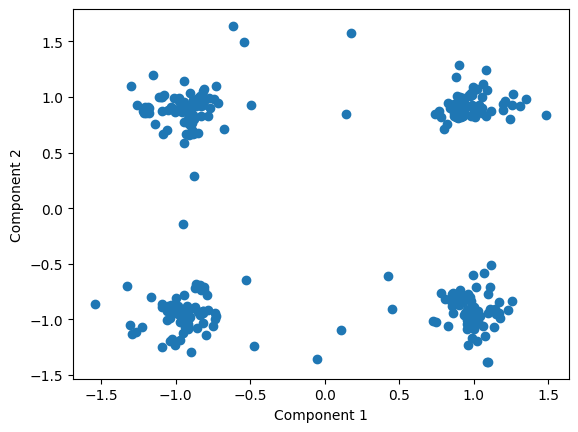

In [33]:
# Visualizing the grouping of words based on generated vector representation
plt.scatter(e[:,6],e[:,3])
plt.xlabel("Component 1")
plt.ylabel("Component 2")

We can see the model tries to group words into different clusters.